In [56]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import trange

sys.path.append('../')

from examples.test_lds import main
from evaluations import gaussian_cdf_evaluation
from kalman_filtering import KalmanFilter

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
true_state_history, estimate_state_history, particle_history, weight_history, obs_history = main(seed=2, save_particles=True, num_iters=10)

[array([10.10382531,  0.10691011]),
 array([9.59065942, 2.40184751]),
 array([8.9325681 , 4.56298567]),
 array([8.19319831, 7.9288611 ]),
 array([5.87029801, 9.00175991]),
 array([ 3.27544235, 10.25806609]),
 array([ 0.85956294, 11.54257725]),
 array([-2.51457953, 11.4065504 ]),
 array([-5.96304388, 10.53184242]),
 array([-8.81743182,  8.32983628])]

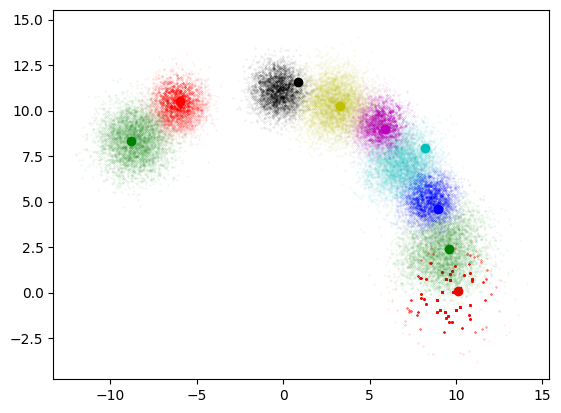

In [43]:
colors = 'rgbcmykw'
for i in range(10):
    plt.scatter(particle_history[i][:, 0], particle_history[i][:, 1], s=1, marker="x", label=str(i), alpha=0.05, color=colors[i%len(colors)])
    plt.scatter(np.array(true_state_history)[i, 0], np.array(true_state_history)[i, 1], color=colors[i%len(colors)])


In [14]:
theta = np.pi / 12
A = np.array([
[np.cos(theta), -np.sin(theta)], 
[np.sin(theta), np.cos(theta)], 
])
C = np.eye(2)

Sigma = np.eye(2) * 1.0
Gamma = np.eye(2) * 0.5

mu0 = np.array([10., 0.])
Gamma0 = np.eye(2) * 1.0

kf = KalmanFilter(A, C, Gamma, Sigma, mu0, Gamma0)

In [15]:
mu, V = kf.filtering(np.array(obs_history))

/var/folders/6b/58_qt7d91c96pg2b8nn3nd2m0000gn/T/ipykernel_28659/218725725.py:7: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mu[i,:], V[i, 0, 0], V[i, 1, 1], .55, color ="gray")


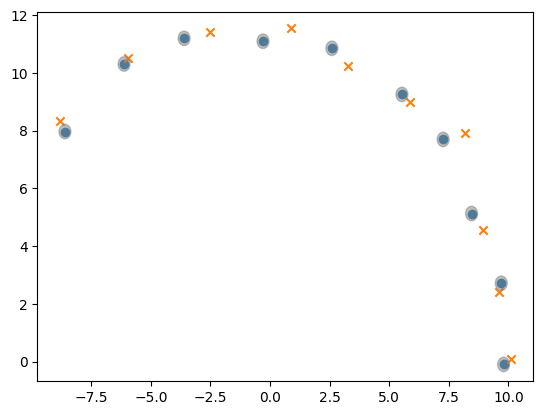

In [32]:
h = plt.subplot()

plt.scatter(mu[:, 0], mu[:, 1])
plt.scatter(np.array(true_state_history)[:, 0], np.array(true_state_history)[:, 1], marker="x")

for i in range(10):
    ell = mpl.patches.Ellipse(mu[i,:], V[i, 0, 0], V[i, 1, 1], .55, color ="gray")
    ell.set_alpha(0.5)
    h.add_artist(ell)

In [57]:
particle_history, weight_history, true_state_history = [], [], []
with trange(50, dynamic_ncols=True) as pbar:
    for i in pbar:
        true_state_history_temp, estimate_state_history, particle_history_temp, weight_history_temp, obs_history = main(save_particles=True, num_iters=20)
        particle_history.append(particle_history_temp)
        weight_history.append(weight_history_temp)
        true_state_history.append(true_state_history_temp)
particle_history = np.concatenate(particle_history, axis=0)
weight_history = np.concatenate(weight_history, axis=0)
true_state_history = np.concatenate(true_state_history, axis=0)

100%|██████████| 50/50 [04:17<00:00,  5.14s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


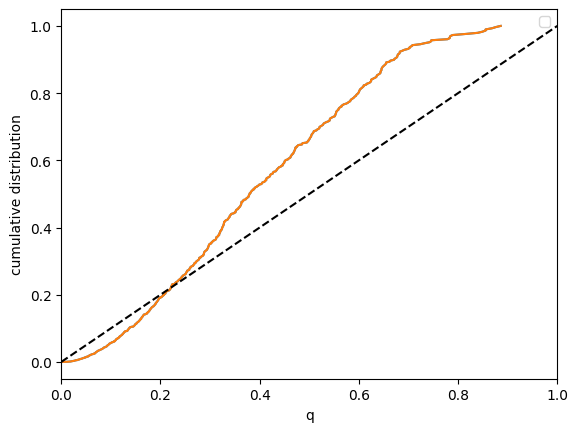

In [58]:
gaussian_cdf_evaluation(particle_history, true_state_history, weight_history)